In [ ]:
import numpy as np
import matplotlib.pyplot as plt



voltage = np.loadtxt(r"C:\Users\ogodh\Documents\Revolve\DivDataRevolve\FSG 24 Voltage cum.txt", delimiter=',')
current = np.loadtxt(r"C:\Users\ogodh\Documents\Revolve\DivDataRevolve\FSG 24 current.txt", delimiter=',')
temp_mess = np.loadtxt(r"C:\Users\ogodh\Documents\Revolve\DivDataRevolve\FSG 24 temp.txt", delimiter=',')


pip_current = current[:,0]  # Extract the first column for pip_current
pip_voltage = voltage[:,0]  # Extract the first column for pip_voltage
pip_temp = temp_mess[:,0]  # Extract the first column for pip_temp



voltage = voltage[:,1]  # Extract the second column for voltage
current = current[:,1]  # Extract the second column for current
temp_mess = np.average(temp_mess[:,1:], axis=1)  # Average the remaining columns for temperature


print("Voltage data length:", len(voltage), "Current data length:", len(current), "Temperature data length:", len(temp_mess))

Voltage data length: 428014 Current data length: 428014 Temperature data length: 51320


In [ ]:

start_temp = 27
time = ((pip_current[0] - pip_current[-1])/1000000) # log timer in seconds
capacity = 11.5  # Ah
print((pip_current[0] - pip_current[-1])/1000000, (pip_temp[0] - pip_temp[-1])/1000000, (pip_voltage[0] - pip_voltage[-1])/1000000)

-2298.487202 -2283.675784 -2298.487202


Frequenzy finder

In [ ]:
current_steplength = np.append( np.diff(pip_current)/1000000, 0)  # Converts to seconds and adds a 0 at the end
voltage_steplength = np.append( np.diff(pip_voltage)/1000000, 0)  # Converts to seconds and adds a 0 at the end
temp_steplength = np.append( np.diff(pip_temp)/1000000, 0)  # Converts to seconds and adds a 0 at the end
print("Current timer length:", current_steplength, "Voltage timer length:", voltage_steplength, "Temperature timer length:", temp_steplength)
print("Current timer length:", len(current_steplength), "Voltage timer length:", len(voltage_steplength), "Temperature timer length:", len(temp_steplength))




Current timer length: [0.002001 0.012035 0.002008 ... 0.146593 0.002013 0.      ] Voltage timer length: [0.002001 0.012035 0.002008 ... 0.146593 0.002013 0.      ] Temperature timer length: [2.000000e-04 2.010000e-04 2.000000e-04 ... 1.405008e+00 2.910000e-04
 0.000000e+00]
Current timer length: 428014 Voltage timer length: 428014 Temperature timer length: 51320


Coulumb count

Timer length: [2.00100000e-03 1.40360000e-02 1.60440000e-02 ... 2.29848519e+03
 2.29848720e+03 2.29848720e+03]


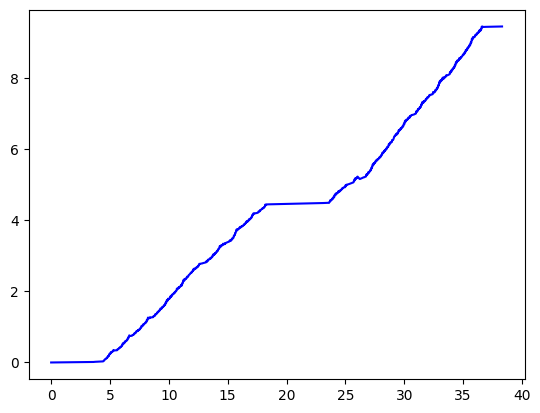

In [ ]:
def coulumbcount(current, current_steplength):
    """
    Calculate the coulomb count from current data.
    :param current: Array of current values.
    :param frequency: Frequency in Hz.
    :return: Array of cumulative charge in Ah.
    """
    charge = current * current_steplength /3600  # Charge in Ah
    return charge.cumsum()

timer = np.cumsum(current_steplength)  # Cumulative time in seconds

plt.plot(timer/60,coulumbcount(current, current_steplength), label='Coulomb Count', color='blue')

SOC - estimate

Coulomb count: [1.09997046e-07 7.70710831e-07 8.81327027e-07 ... 9.43970435e+00
 9.43970460e+00 9.43970460e+00] Length: 428014
Starting SOC =  93.2 %


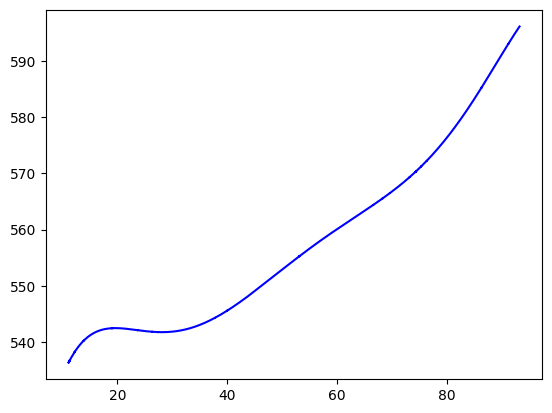

In [ ]:
print("Coulomb count:", coulumbcount(current, current_steplength) , "Length:", len(coulumbcount(current, current_steplength)))



#OCV curve for hole pack
def ocv(x):
    function = ((-0.00000000005293025538 * x**6) + (0.00000001780034323252 * x**5) - (0.0000023449513943119 * x**4) + (0.000152999318808966 * x**3) - (0.00507875729130092 * x**2) + (0.0811881395834462 * x) + 3.27240105786314)*144  # OCV curve for the entire pack, multiplied by 144 to get the voltage
    # function = -0.00000000360971643331*x**6 + 0.00000149485382770393*x**5 - 0.00024182241439912800*x**4 + 0.01966038262184640000*x**3 - 0.84273014239105400000*x**2 + 18.21222294308470000000*x + 400.75117609913800000000

    return function # For entire pack, multiply by 144 to get the voltage

x = np.linspace(0, 100, 100) # Generate x values from 0 to 100 for SOC

# Define the function whose root we want to find: ocv(x) - voltage[1]
def ocv_minus_voltage(x):
    return ocv(x) - voltage[0]  # Use the first voltage value for comparison

# Use root_scalar to find x where ocv(x) = voltage[1]
result = root_scalar(ocv_minus_voltage, bracket=[0, 100], method='brentq')
soc_start = result.root if result.converged else None
print("Starting SOC = ",round(soc_start,2), "%")
# soc_start = 94

x = (capacity*soc_start/100 - coulumbcount(current, current_steplength))/capacity * 100  # Calculate SOC in percentage


# print("x values:", x)

plt.plot(x, ocv(x), label='OCV Curve', color='blue')


Check curves

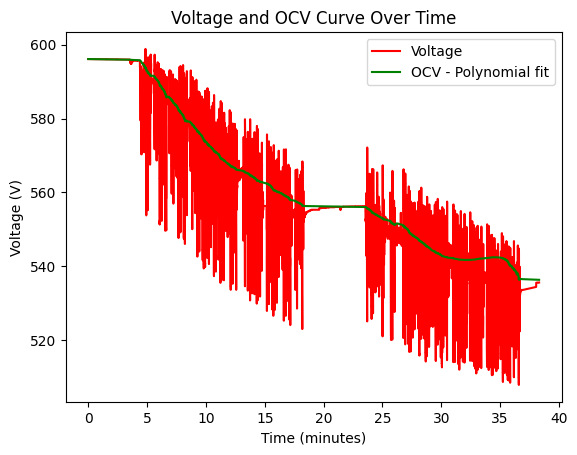

In [ ]:
plt.plot(timer/60, voltage, label='Voltage', color='red')
plt.plot(timer/60, ocv(x), label='OCV - Polynomial fit', color='green')
plt.xlabel('Time (minutes)')
plt.ylabel('Voltage (V)')
plt.title('Voltage and OCV Curve Over Time')
plt.legend()


Calculate overpotential

Weighted average efficiency: 0.01400587199641705 %


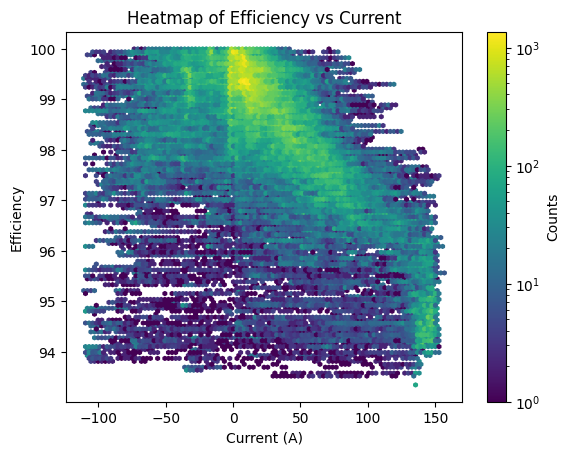

In [ ]:
from scipy.optimize import curve_fit


overpotential = voltage - ocv(x)  # Calculate overpotential
efficiency = (ocv(x) - abs(overpotential)) / ocv(x) * 100  # Calculate efficiency in percentage  
mask = np.abs(current) >= 0.8
plt.figure()
hb = plt.hexbin((current[mask]), efficiency[mask], gridsize=100, cmap='viridis', bins='log')
plt.colorbar(label='Counts')
plt.xlabel('Current (A)')
plt.ylabel('Efficiency')
plt.title('Heatmap of Efficiency vs Current')
plt.gca().set_facecolor('1')  # Set background color to dark gray

print("Weighted average efficiency:", np.mean(abs(overpotential*current)/abs(ocv(x)*current)), "%") #usbdfusd

Efficiency formula

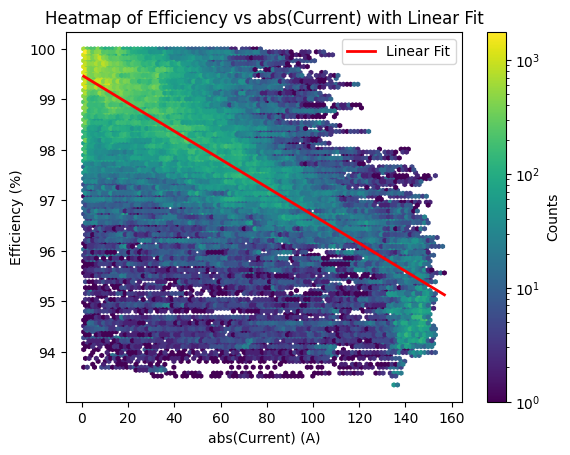

Linear fit = 99.48063126093506 + -0.027746022417156513 Current


In [ ]:
# Fit a linear model to the data
abs_current = np.abs(current[mask])
eff = efficiency[mask]
m, c = np.polyfit(abs_current, eff, 1)
I_fit = np.linspace(abs_current.min(), abs_current.max(), 100)

# Overlay the linear fit on the heatmap
plt.figure()
hb = plt.hexbin(abs_current, eff, gridsize=100, cmap='viridis', bins='log')
plt.plot(I_fit, m * I_fit + c, color='red', label='Linear Fit', linewidth=2)
plt.colorbar(label='Counts')
plt.xlabel('abs(Current) (A)')
plt.ylabel('Efficiency (%)')
plt.title('Heatmap of Efficiency vs abs(Current) with Linear Fit')
plt.legend()
plt.gca().set_facecolor('1')
plt.show()

print('Linear fit =', c, '+', m, 'Current')


Splitting C and DC

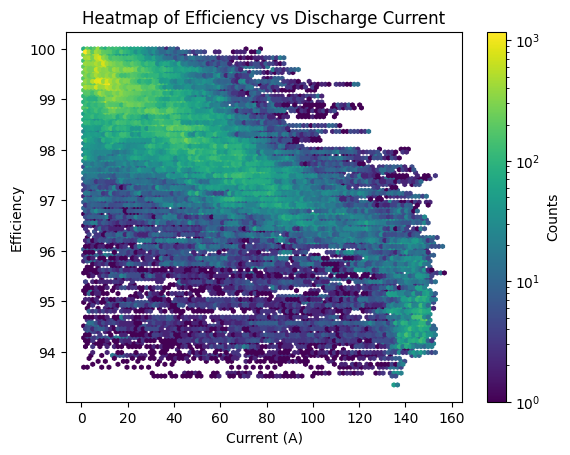

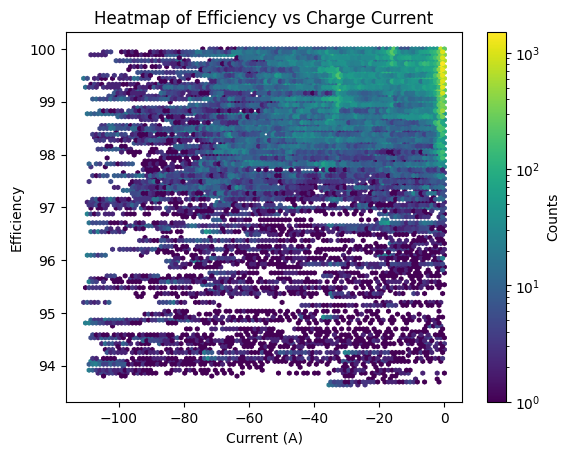

In [ ]:
# Mask for currents > 1 to avoid standstill
mask_discharge = current > 1
plt.figure()
hb_pos = plt.hexbin(current[mask_discharge], efficiency[mask_discharge], gridsize=100, cmap='viridis', bins='log')
plt.colorbar(label='Counts')
plt.xlabel('Current (A)')
plt.ylabel('Efficiency')
plt.title('Heatmap of Efficiency vs Discharge Current')
plt.gca().set_facecolor('1')  # Set background color to dark gray

# Mask for currents < 0
mask_charge = current < 0
plt.figure()
hb_neg = plt.hexbin(current[mask_charge], efficiency[mask_charge], gridsize=100, cmap='viridis', bins='log')
plt.colorbar(label='Counts')
plt.xlabel('Current (A)')
plt.ylabel('Efficiency')
plt.title('Heatmap of Efficiency vs Charge Current')
plt.gca().set_facecolor('1')  # Set background color to dark gray

Linear fit for C and DC

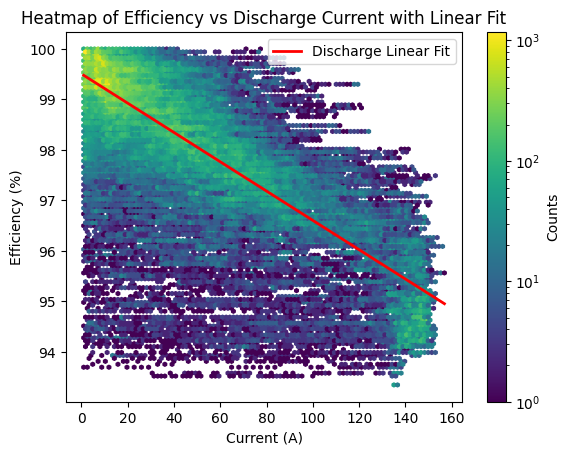

Discharge Linear fit: Efficiency = 99.5065 + -0.0290 * Current


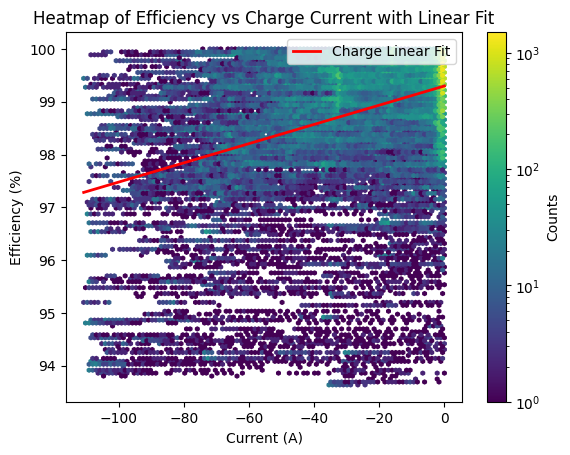

Charge Linear fit: Efficiency = 99.2985 + 0.0182 * Current


In [ ]:
# Linear fit for discharge (DC)
current_discharge = current[mask_discharge]
eff_discharge = efficiency[mask_discharge]
m_dis, c_dis = np.polyfit(current_discharge, eff_discharge, 1)
I_fit_dis = np.linspace(current_discharge.min(), current_discharge.max(), 100)

plt.figure()
hb_dis = plt.hexbin(current_discharge, eff_discharge, gridsize=100, cmap='viridis', bins='log')
plt.plot(I_fit_dis, m_dis * I_fit_dis + c_dis, color='red', label='Discharge Linear Fit', linewidth=2)
plt.colorbar(label='Counts')
plt.xlabel('Current (A)')
plt.ylabel('Efficiency (%)')
plt.title('Heatmap of Efficiency vs Discharge Current with Linear Fit')
plt.legend()
plt.gca().set_facecolor('1')
plt.show()

print('Discharge Linear fit: Efficiency = {:.4f} + {:.4f} * Current'.format(c_dis, m_dis))

# Linear fit for charge (C)
current_charge = current[mask_charge]
eff_charge = efficiency[mask_charge]
m_chg, c_chg = np.polyfit(current_charge, eff_charge, 1)
I_fit_chg = np.linspace(current_charge.min(), current_charge.max(), 100)

plt.figure()
hb_chg = plt.hexbin(current_charge, eff_charge, gridsize=100, cmap='viridis', bins='log')
plt.plot(I_fit_chg, m_chg * I_fit_chg + c_chg, color='red', label='Charge Linear Fit', linewidth=2)
plt.colorbar(label='Counts')
plt.xlabel('Current (A)')
plt.ylabel('Efficiency (%)')
plt.title('Heatmap of Efficiency vs Charge Current with Linear Fit')
plt.legend()
plt.gca().set_facecolor('1')
plt.show()

print('Charge Linear fit: Efficiency = {:.4f} + {:.4f} * Current'.format(c_chg, m_chg))

Find Mean currents

In [ ]:
mean_charge = np.mean(efficiency[mask_charge])
mean_discharge = np.mean(efficiency[mask_discharge])
mean_current_charge = np.mean(current[mask_charge])
mean_current_discharge = np.mean(current[mask_discharge])
print("Mean Charge Efficiency:", mean_charge, "% at Current:", mean_current_charge, "A")
print("Mean Discharge Efficiency:", mean_discharge, "% at Current:", mean_current_discharge, "A")

Mean Charge Efficiency: 98.82860547817192 % at Current: -25.824846848878042 A
Mean Discharge Efficiency: 98.22259476724044 % at Current: 44.21782962300641 A


Heat generation

Text(0.5, 1.0, 'Temperature vs Time')

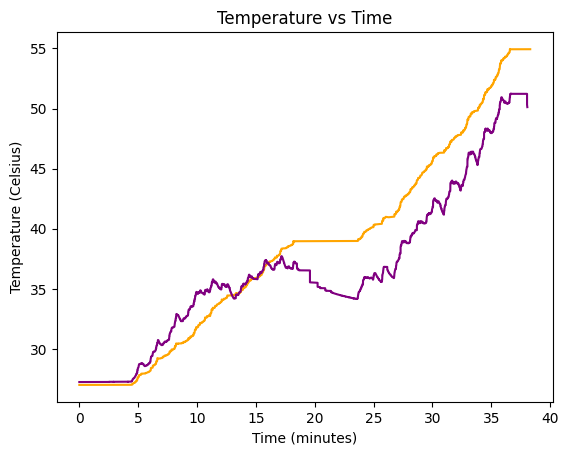

In [ ]:
cp = 600
cp = cp*0.121*288  # Specific heat capacity in J/(kg*K) for the cell, assuming 1300 J/(kg*K) and mass of 0.121 kg

def heat_generation(current, overpotential, current_steplength):
    """
    Calculate heat generation from current and overpotential.
    :param current: Array of current values.
    :param overpotential: Array of overpotential values.
    :return: Array of heat generation in J.
    """
    return current * abs(overpotential) * current_steplength # Heat generation in J

temp = start_temp + np.cumsum(heat_generation(current, overpotential, current_steplength)) / cp  # Calculate temperature in Celsius

plt.plot(timer/60, temp, label='Temperature', color='orange')
plt.plot(np.cumsum(temp_steplength)/60, temp_mess, label='Temperature messured', color='purple')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature vs Time')